In [230]:
import os
import cv2
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random
import math
import copy
from torch.utils.data import Dataset, ConcatDataset, Subset
from sklearn.model_selection import train_test_split

In [231]:

class RemapDataset(Dataset):
    def __init__(self, dataset, global_class_to_id):
        self.dataset = dataset
        self.global_class_to_id = global_class_to_id

        self.classes = list(global_class_to_id.keys())
        self.class_to_id = global_class_to_id
        self.id_to_class = {v: k for k, v in global_class_to_id.items()}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, local_label = self.dataset[idx]
        class_name = self.dataset.id_to_class[local_label]
        global_label = self.global_class_to_id[class_name]
        return image, global_label



def build_train_val_datasets(
    datasets:list[Dataset],
    val_size:float=0.2,
    random_state:int=42
):
    
    all_classes = set()
    for ds in datasets:
        all_classes.update(ds.classes)

    all_classes = sorted(all_classes)
    global_class_to_id = {c: i for i, c in enumerate(all_classes)}

    remapped_datasets = [
        RemapDataset(ds, global_class_to_id)
        for ds in datasets
    ]

    full_dataset = ConcatDataset(remapped_datasets)

    labels = []
    for ds in remapped_datasets:
        for i in range(len(ds)):
            _, lbl = ds[i]
            labels.append(lbl)

    indices = list(range(len(full_dataset)))

    train_idx, val_idx = train_test_split(
        indices,
        test_size=val_size,
        stratify=labels,
        random_state=random_state
    )

    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

    train_dataset.classes = all_classes
    val_dataset.classes = all_classes
    train_dataset.class_to_id = global_class_to_id
    val_dataset.class_to_id = global_class_to_id
    train_dataset.id_to_class = {v: k for k, v in global_class_to_id.items()}
    val_dataset.id_to_class = {v: k for k, v in global_class_to_id.items()}

    return train_dataset, val_dataset


In [232]:
ROOT_DIR = "data_YOLO" 
CLASS_NAMES = ['hornet', 'false_knight', 'crystal'] 

ATTACK_TO_ID = {
    'Crystal_Guard': 0, 'jump_move': 1, 'hand_laser': 2, 'scream_beams': 3,
    'False_Knight': 4, 'trowing_wave': 5, 'hit_from_heaven': 6, 'left-right-smashing': 7,
    'just_jumpmove': 8,
    'hornet': 9, 'hornet_ram': 10, 'hornet_drill': 11, 'hornet_throw': 12, 'hornet_silk': 13
}

In [ ]:
class HollowKnightDataset(Dataset):
    def __init__(self, root_dir, class_names, attack_to_id, max_frames, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.attack_to_id = attack_to_id
        self.samples = []
        self.id_to_class = {v: k for k, v in attack_to_id.items()}
        self.classes = [k for k, v in sorted(attack_to_id.items(), key=lambda item: item[1])]
        
        for enemy in class_names:
            enemy_folder = f"{enemy}_YOLO"
            enemy_path = os.path.join(root_dir, enemy_folder)
            xml_path = os.path.join(enemy_path, "annotations.xml")
            
            # Лимит кадров для текущего врага
            limit = max_frames.get(enemy_folder, 999999)
            enemy_count = 0 # Счетчик найденных размеченных кадров
            
            if not os.path.exists(xml_path):
                print(f"XML не найден в {xml_path}")
                continue

            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            img_dir = enemy_path
            if os.path.exists(os.path.join(enemy_path, "obj_train_data")):
                img_dir = os.path.join(enemy_path, "obj_train_data")

            for image_tag in root.findall('image'):
                
                if enemy_count >= limit:
                    break
                
                img_name = image_tag.get('name')
                if not img_name.lower().endswith(('.png', '.jpg')):
                    img_name += ".png"
                
                img_path = os.path.join(img_dir, img_name)
                

                attack_label = None
                for tag in image_tag.findall('tag'):
                    if tag.get('label') in self.attack_to_id:
                        attack_label = tag.get('label')
                        break
                
                boxes = image_tag.findall('box')
                if attack_label is None and boxes:
                    for box in boxes:
                        if box.get('label') in self.attack_to_id:
                            attack_label = box.get('label')
                            break

           
                if attack_label is not None and boxes:
                    selected_box = boxes[0]
                    for box in boxes:
                        if box.get('label') == attack_label:
                            selected_box = box
                            break
                    
                    self.samples.append({
                        'img_path': img_path,
                        'bbox': [float(selected_box.get('xtl')), float(selected_box.get('ytl')), 
                                 float(selected_box.get('xbr')), float(selected_box.get('ybr'))],
                        'label': self.attack_to_id[attack_label]
                    })
                    enemy_count += 1
            
            print(f"{enemy_folder}: загружено {enemy_count} размеченных кадров.")

        self.targets = [s['label'] for s in self.samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        sample = self.samples[idx]
        image = cv2.imread(sample['img_path'])
        if image is None: return torch.zeros((3, 224, 224)), sample['label']
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape
        xtl, ytl, xbr, ybr = map(int, sample['bbox'])
        crop = image[max(0, ytl):min(h, ybr), max(0, xtl):min(w, xbr)]
        if crop.size == 0: crop = cv2.resize(image, (224, 224))
        if self.transform:
            augmented = self.transform(image=crop)
            return augmented['image'], sample['label']
        return crop, sample['label']

In [234]:
ENEMY_CLASSES = {
    "hornet_YOLO": 0,
    "false_knight_YOLO": 1,
    "crystal_YOLO": 2
}

MAX_LABELED_FRAMES = {
    "hornet_YOLO": 2500,
    "false_knight_YOLO": 2270,
    "crystal_YOLO": 1120
}

# Список всех атак для классификатора
ATTACK_MAPPING = {
    "crystal_YOLO": ["Crystal_Guard", "jump_move", "hand_laser", "scream_beams"],
    "false_knight_YOLO": ["False_Knight", "trowing_wave", "hit_from_heaven", "left-right-smashing", "just_jumpmove"],
    "hornet_YOLO": ["hornet", "hornet_ram", "hornet_drill", "hornet_throw", "hornet_silk"]
}

ALL_ATTACK_CLASSES = []
for enemy in ATTACK_MAPPING:
    ALL_ATTACK_CLASSES.extend(ATTACK_MAPPING[enemy])

ATTACK_TO_ID = {name: i for i, name in enumerate(ALL_ATTACK_CLASSES)}

ID_TO_ATTACK = {i: name for name, i in ATTACK_TO_ID.items()}

print(f"Всего классов атак: {len(ALL_ATTACK_CLASSES)}")
print(f"Список классов: {ALL_ATTACK_CLASSES}")

Всего классов атак: 14
Список классов: ['Crystal_Guard', 'jump_move', 'hand_laser', 'scream_beams', 'False_Knight', 'trowing_wave', 'hit_from_heaven', 'left-right-smashing', 'just_jumpmove', 'hornet', 'hornet_ram', 'hornet_drill', 'hornet_throw', 'hornet_silk']


In [235]:
num_classes = len(ALL_ATTACK_CLASSES)

In [ ]:
from torch.utils.data import Subset
import math

def split_stratified_chronologically(dataset, train_ratio=0.8):
    train_indices = []
    val_indices = []
    
   
    label_to_indices = {}
    
  
    for idx, sample in enumerate(dataset.samples):
        lbl = sample['label']
        if lbl not in label_to_indices:
            label_to_indices[lbl] = []
        label_to_indices[lbl].append(idx)
    
   
    for lbl, indices in label_to_indices.items():
      
        
        split_point = int(len(indices) * train_ratio)
        

        if split_point == 0 and len(indices) > 0:

            train_indices.append(indices[0])
            if len(indices) > 1:
                val_indices.extend(indices[1:])
        else:
           
            val_indices.extend(indices[split_point:])
            
   
    train_indices = [int(i) for i in train_indices]
    val_indices = [int(i) for i in val_indices]

    print(f"Разбиение готово: Train: {len(train_indices)}, Val: {len(val_indices)}")
    
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

In [ ]:
def show_dataset_sample(dataset, idx=0):
    image, label = dataset[idx]
    
   
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()
        # Денормализация, если применялась (примерные значения ImageNet)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    if hasattr(dataset, 'id_to_class'):
        class_name = dataset.id_to_class.get(label, f"ID: {label}")
    elif 'ID_TO_ATTACK' in globals():
        class_name = ID_TO_ATTACK.get(label, f"ID: {label}")
    else:
        class_name = f"Class ID: {label}"

    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
    plt.show()

In [ ]:
class TransformWrapper(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
        base_ds = dataset.dataset if hasattr(dataset, 'dataset') else dataset
        
        self.classes = getattr(base_ds, 'classes', [])
        self.id_to_class = getattr(base_ds, 'id_to_class', {})

        if not self.id_to_class and 'ATTACK_TO_ID' in globals():
            self.id_to_class = {v: k for k, v in ATTACK_TO_ID.items()}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [239]:
ROOT_DIR = "data_YOLO" 

In [240]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),                # Отражение по горизонтали
    A.Rotate(limit=15, p=0.5),              # Легкие повороты
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


from sklearn.model_selection import train_test_split


full_dataset_no_transform = HollowKnightDataset(
    root_dir=ROOT_DIR,           
    class_names=CLASS_NAMES,      # ['hornet', 'false_knight', 'crystal']
    attack_to_id=ATTACK_TO_ID,
    max_frames=MAX_LABELED_FRAMES
)


targets = full_dataset_no_transform.targets
indices = np.arange(len(full_dataset_no_transform))

train_idx, val_idx = split_stratified_chronologically(full_dataset_no_transform, train_ratio=0.8)



BATCH_SIZE = 32


train_subset, val_subset = split_stratified_chronologically(full_dataset_no_transform, train_ratio=0.8)


train_ds = TransformWrapper(train_subset, transform=train_transform)
val_ds = TransformWrapper(val_subset, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # Здесь shuffle=True можно, так как это уже внутри эпохи
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

✅ hornet_YOLO: загружено 2500 размеченных кадров.
✅ false_knight_YOLO: загружено 2270 размеченных кадров.
✅ crystal_YOLO: загружено 1120 размеченных кадров.
Разбиение готово: Train: 4705, Val: 1185
Разбиение готово: Train: 4705, Val: 1185


In [243]:
num_classes

14

In [244]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")
if device.type == 'cuda':
    print(f"Имя GPU: {torch.cuda.get_device_name(0)}")

Используется устройство: cuda
Имя GPU: NVIDIA GeForce RTX 4060 Ti


In [245]:
import torchvision.models as models
def get_pretrained_model(num_classes):
    model = models.resnet18(pretrained=True)
    # Глобально размораживаем, так как датасет специфичный
    for param in model.parameters():
        param.requires_grad = True

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

# Инициализация
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_pretrained_model(num_classes=len(ATTACK_TO_ID))
model = model.to(device)
print(f"Модель ResNet18 загружена для {len(ATTACK_TO_ID)} классов.")

c:\Users\Xenia\anaconda3\envs\cv_env_new\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Xenia\anaconda3\envs\cv_env_new\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Модель ResNet18 загружена для 14 классов.


In [ ]:
def print_dataset_stats(train_ds, val_ds, all_class_names):
    def get_stats(dataset):
        labels = []
        # Извлекаем метки из Subset
        for i in range(len(dataset)):
            _, lbl = dataset[i]
            labels.append(lbl)
        return np.bincount(labels, minlength=len(all_class_names))

    train_counts = get_stats(train_ds)
    val_counts = get_stats(val_ds)

    print(f"{'Class Name':<25} | {'Train':<7} | {'Val':<7}")
    print("-" * 45)
    for i, name in enumerate(all_class_names):
        print(f"{name:<25} | {train_counts[i]:<7} | {val_counts[i]:<7}")
    
    print("-" * 45)
    print(f"{'TOTAL':<25} | {sum(train_counts):<7} | {sum(val_counts):<7}")



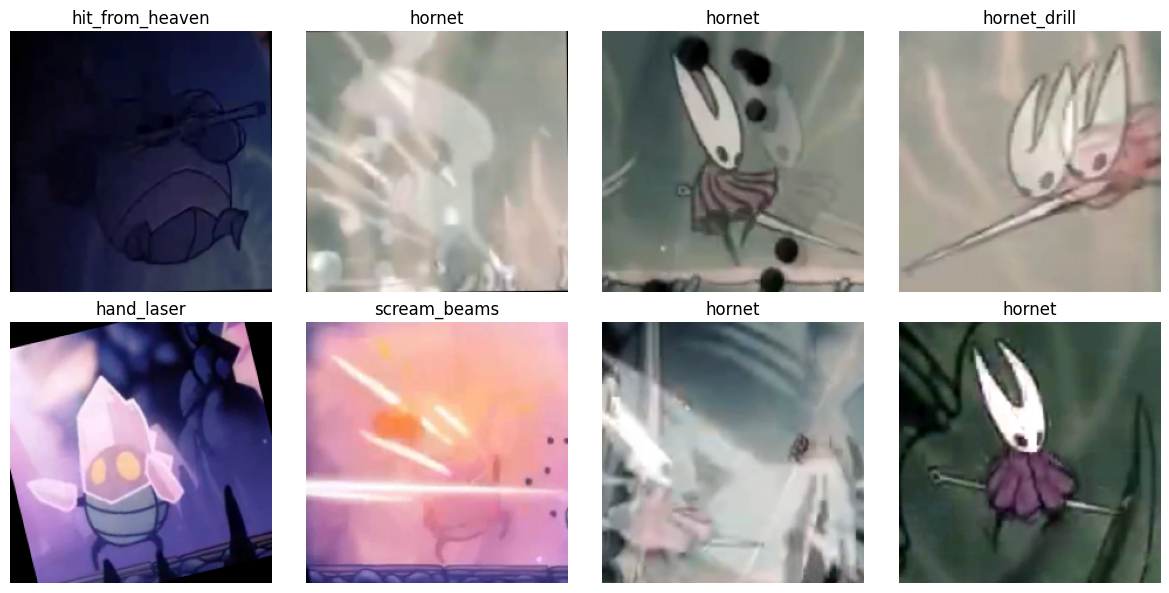

In [ ]:
def show_augmented_batch(dataloader, id_to_class, n_images=8):

    images, labels = next(iter(dataloader))
    
    rows = 2
    cols = math.ceil(n_images / rows)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    # Параметры денормализации (ImageNet)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(n_images):
        img = images[i]
        label = labels[i].item()
        img = img * std + mean
        img = img.clamp(0, 1).permute(1, 2, 0).numpy()
        
        axes[i].imshow(img)
        axes[i].set_title(f"{id_to_class[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_augmented_batch(train_loader, {v: k for k, v in ATTACK_TO_ID.items()})

In [248]:
from sklearn.utils.class_weight import compute_class_weight

# Получаем все метки из тренировочного набора
train_labels = [label for _, label in train_ds]

# Считаем веса
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Веса классов:", class_weights)

Веса классов: tensor([2.2555, 1.6157, 0.9284, 1.9204, 0.4376, 1.7688, 0.8962, 1.6474, 1.2177,
        0.2211, 2.4711, 2.8972, 1.9204, 6.5896], device='cuda:0')


In [249]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Learning rate поменьше для фантюнинга

In [254]:
def train_action_classifier(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    
    epochs,
    device=0,
    save_path='best_action_model_multi_class_last.pth',
    use_mixup=False,
    scheduler=None,
    mixup_alpha=0.2
):
    model = model.to(device)

    history = {
        'loss_train': [],
        'acc_train': [],
        'loss_val': [],
        'acc_val': []
    }

    best_acc = 0.0
    best_state_dict = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            if use_mixup and mixup_alpha > 0:
                lam = np.random.beta(mixup_alpha, mixup_alpha)
                index = torch.randperm(images.size(0)).to(device)

                mixed_images = lam * images + (1 - lam) * images[index]
                output = model(mixed_images)

                y_a, y_b = labels, labels[index]
                loss = lam * criterion(output, y_a) + (1 - lam) * criterion(output, y_b)

            else:
                output = model(images)
                loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_correct / train_total

        history['loss_train'].append(avg_train_loss)
        history['acc_train'].append(avg_train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)

                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_correct / val_total

        history['loss_val'].append(avg_val_loss)
        history['acc_val'].append(avg_val_acc)

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_acc)
            else:
                scheduler.step()

        if avg_val_acc > best_acc:
            best_acc = avg_val_acc
            best_state_dict = copy.deepcopy(model.state_dict())

            if save_path is not None:
                torch.save(best_state_dict, save_path)

            saved_msg = f"-> Best model saved (val_acc={best_acc:.4f})"
        else:
            saved_msg = ""

        print(
            f'Epoch [{epoch+1}/{epochs}] '
            f'Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | '
            f'Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f} {saved_msg}'
        )
        print('-' * 80)

    model.load_state_dict(best_state_dict)

    return model, history, best_acc

In [255]:
test_model, history, best_acc = train_action_classifier(model, train_loader, val_loader, criterion, optimizer, epochs=30)

Epoch 1/30:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 148/148 [01:04<00:00,  2.28it/s, loss=3.01] 


Epoch [1/30] Train Loss: 0.7781 | Train Acc: 0.7328 | Val Loss: 0.9523 | Val Acc: 0.6726 -> Best model saved (val_acc=0.6726)
--------------------------------------------------------------------------------


Epoch 2/30: 100%|██████████| 148/148 [01:05<00:00,  2.27it/s, loss=2.87]  


Epoch [2/30] Train Loss: 0.2158 | Train Acc: 0.9322 | Val Loss: 1.0235 | Val Acc: 0.6363 
--------------------------------------------------------------------------------


Epoch 3/30: 100%|██████████| 148/148 [01:06<00:00,  2.22it/s, loss=3.19]  


Epoch [3/30] Train Loss: 0.1412 | Train Acc: 0.9594 | Val Loss: 0.7830 | Val Acc: 0.7232 -> Best model saved (val_acc=0.7232)
--------------------------------------------------------------------------------


Epoch 4/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=3.47]  


Epoch [4/30] Train Loss: 0.1114 | Train Acc: 0.9683 | Val Loss: 1.0228 | Val Acc: 0.7013 
--------------------------------------------------------------------------------


Epoch 5/30: 100%|██████████| 148/148 [01:06<00:00,  2.24it/s, loss=3.04]   


Epoch [5/30] Train Loss: 0.0883 | Train Acc: 0.9796 | Val Loss: 0.7232 | Val Acc: 0.7907 -> Best model saved (val_acc=0.7907)
--------------------------------------------------------------------------------


Epoch 6/30: 100%|██████████| 148/148 [01:06<00:00,  2.24it/s, loss=3.66]   


Epoch [6/30] Train Loss: 0.0850 | Train Acc: 0.9841 | Val Loss: 0.8309 | Val Acc: 0.7662 
--------------------------------------------------------------------------------


Epoch 7/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=2.29]   


Epoch [7/30] Train Loss: 0.0552 | Train Acc: 0.9875 | Val Loss: 0.9595 | Val Acc: 0.7460 
--------------------------------------------------------------------------------


Epoch 8/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=3.01]   


Epoch [8/30] Train Loss: 0.0547 | Train Acc: 0.9894 | Val Loss: 0.7538 | Val Acc: 0.7679 
--------------------------------------------------------------------------------


Epoch 9/30: 100%|██████████| 148/148 [01:06<00:00,  2.24it/s, loss=2.9]    


Epoch [9/30] Train Loss: 0.0591 | Train Acc: 0.9864 | Val Loss: 0.7736 | Val Acc: 0.7654 
--------------------------------------------------------------------------------


Epoch 10/30: 100%|██████████| 148/148 [01:06<00:00,  2.24it/s, loss=2.94]   


Epoch [10/30] Train Loss: 0.0514 | Train Acc: 0.9889 | Val Loss: 0.8105 | Val Acc: 0.7713 
--------------------------------------------------------------------------------


Epoch 11/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=1.95]   


Epoch [11/30] Train Loss: 0.0429 | Train Acc: 0.9911 | Val Loss: 1.1704 | Val Acc: 0.6852 
--------------------------------------------------------------------------------


Epoch 12/30: 100%|██████████| 148/148 [01:06<00:00,  2.24it/s, loss=2.41]   


Epoch [12/30] Train Loss: 0.0502 | Train Acc: 0.9887 | Val Loss: 1.5018 | Val Acc: 0.5890 
--------------------------------------------------------------------------------


Epoch 13/30: 100%|██████████| 148/148 [01:06<00:00,  2.22it/s, loss=1.29]   


Epoch [13/30] Train Loss: 0.0471 | Train Acc: 0.9892 | Val Loss: 1.3179 | Val Acc: 0.5755 
--------------------------------------------------------------------------------


Epoch 14/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=0.684]  


Epoch [14/30] Train Loss: 0.0408 | Train Acc: 0.9879 | Val Loss: 1.1139 | Val Acc: 0.7004 
--------------------------------------------------------------------------------


Epoch 15/30: 100%|██████████| 148/148 [01:06<00:00,  2.22it/s, loss=4.68]   


Epoch [15/30] Train Loss: 0.0562 | Train Acc: 0.9913 | Val Loss: 1.0628 | Val Acc: 0.7451 
--------------------------------------------------------------------------------


Epoch 16/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=0.673]  


Epoch [16/30] Train Loss: 0.0241 | Train Acc: 0.9945 | Val Loss: 0.9899 | Val Acc: 0.7350 
--------------------------------------------------------------------------------


Epoch 17/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=4]      


Epoch [17/30] Train Loss: 0.0449 | Train Acc: 0.9936 | Val Loss: 0.8895 | Val Acc: 0.7907 
--------------------------------------------------------------------------------


Epoch 18/30: 100%|██████████| 148/148 [01:06<00:00,  2.22it/s, loss=0.808]  


Epoch [18/30] Train Loss: 0.0224 | Train Acc: 0.9953 | Val Loss: 1.0000 | Val Acc: 0.7646 
--------------------------------------------------------------------------------


Epoch 19/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=0.439]   


Epoch [19/30] Train Loss: 0.0186 | Train Acc: 0.9949 | Val Loss: 1.2821 | Val Acc: 0.6970 
--------------------------------------------------------------------------------


Epoch 20/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=0.322]   


Epoch [20/30] Train Loss: 0.0206 | Train Acc: 0.9953 | Val Loss: 0.9340 | Val Acc: 0.7451 
--------------------------------------------------------------------------------


Epoch 21/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=0.215]   


Epoch [21/30] Train Loss: 0.0161 | Train Acc: 0.9968 | Val Loss: 1.0240 | Val Acc: 0.6793 
--------------------------------------------------------------------------------


Epoch 22/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=0.2]    


Epoch [22/30] Train Loss: 0.0271 | Train Acc: 0.9936 | Val Loss: 0.9626 | Val Acc: 0.7426 
--------------------------------------------------------------------------------


Epoch 23/30: 100%|██████████| 148/148 [01:06<00:00,  2.22it/s, loss=0.178]   


Epoch [23/30] Train Loss: 0.0220 | Train Acc: 0.9951 | Val Loss: 0.9809 | Val Acc: 0.7882 
--------------------------------------------------------------------------------


Epoch 24/30: 100%|██████████| 148/148 [01:06<00:00,  2.22it/s, loss=5.62]    


Epoch [24/30] Train Loss: 0.0618 | Train Acc: 0.9930 | Val Loss: 1.1780 | Val Acc: 0.7392 
--------------------------------------------------------------------------------


Epoch 25/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=0.352]   


Epoch [25/30] Train Loss: 0.0232 | Train Acc: 0.9919 | Val Loss: 0.9092 | Val Acc: 0.7553 
--------------------------------------------------------------------------------


Epoch 26/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=3.98]    


Epoch [26/30] Train Loss: 0.0450 | Train Acc: 0.9934 | Val Loss: 1.1955 | Val Acc: 0.7215 
--------------------------------------------------------------------------------


Epoch 27/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=1.78]    


Epoch [27/30] Train Loss: 0.0309 | Train Acc: 0.9936 | Val Loss: 1.2033 | Val Acc: 0.7097 
--------------------------------------------------------------------------------


Epoch 28/30: 100%|██████████| 148/148 [01:06<00:00,  2.22it/s, loss=3.07]    


Epoch [28/30] Train Loss: 0.0423 | Train Acc: 0.9945 | Val Loss: 1.1035 | Val Acc: 0.7451 
--------------------------------------------------------------------------------


Epoch 29/30: 100%|██████████| 148/148 [01:06<00:00,  2.23it/s, loss=3.53]    


Epoch [29/30] Train Loss: 0.0385 | Train Acc: 0.9928 | Val Loss: 1.6641 | Val Acc: 0.5190 
--------------------------------------------------------------------------------


Epoch 30/30: 100%|██████████| 148/148 [01:06<00:00,  2.22it/s, loss=3.51]    


Epoch [30/30] Train Loss: 0.0534 | Train Acc: 0.9896 | Val Loss: 1.4877 | Val Acc: 0.5823 
--------------------------------------------------------------------------------


In [256]:
# Сохраняем веса обученной модели
torch.save(test_model.state_dict(), 'hollow_knight_model_v2.pth')
print("Веса модели успешно сохранены в файл hollow_knight_model_v2.pth")

Веса модели успешно сохранены в файл hollow_knight_model_v2.pth


In [257]:
torch.save(test_model, 'full_model_hk2.pt')

In [258]:
def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Обратное преобразование нормализации для отображения"""
    mean = np.array(mean)
    std = np.array(std)
    # Tensor (C, H, W) -> Numpy (H, W, C)
    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

In [259]:


def show_classified_crops(
    dataloader,
    model,
    class_names,
    device,
    max_classes=25
):
    model.eval()

    num_classes = len(class_names)
    class_indices = list(range(num_classes))

    if num_classes > max_classes:
        class_indices = random.sample(class_indices, max_classes)

    class_indices = set(class_indices)

    samples = {}

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            for img, gt, pred in zip(images, labels, preds):
                gt = gt.item()
                if gt in class_indices and gt not in samples:
                    samples[gt] = (
                        img.cpu(),
                        gt,
                        pred.cpu().item()
                    )

                if len(samples) == len(class_indices):
                    break
            if len(samples) == len(class_indices):
                break

    if not samples:
        print("No samples found for visualization")
        return

    n = len(samples)
    cols = min(5, n)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten() if n > 1 else [axes]

    for ax in axes[n:]:
        ax.axis('off')

    for ax, (cls_id, (img, gt, pred)) in zip(axes, samples.items()):
        img = img.permute(1, 2, 0).numpy()
        gt_name = class_names[gt]
        pred_name = class_names[pred]

        color = 'green' if gt == pred else 'red'

        ax.imshow(img)
        ax.set_title(
            f"GT: {gt_name}\nPred: {pred_name}",
            fontsize=10,
            color=color
        )
        ax.axis('off')

        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()


In [266]:
test_model =  get_pretrained_model(num_classes=len(ATTACK_TO_ID)) 
test_model.load_state_dict(torch.load('best_action_model_multi_class_last.pth'))
test_model = test_model.to(device)
print("модель успешно загружена из файла.")

C:\Users\Xenia\AppData\Local\Temp\ipykernel_28504\2899032859.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load('best_action_model_mul

модель успешно загружена из файла.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466563..2.448279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.210292..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.6

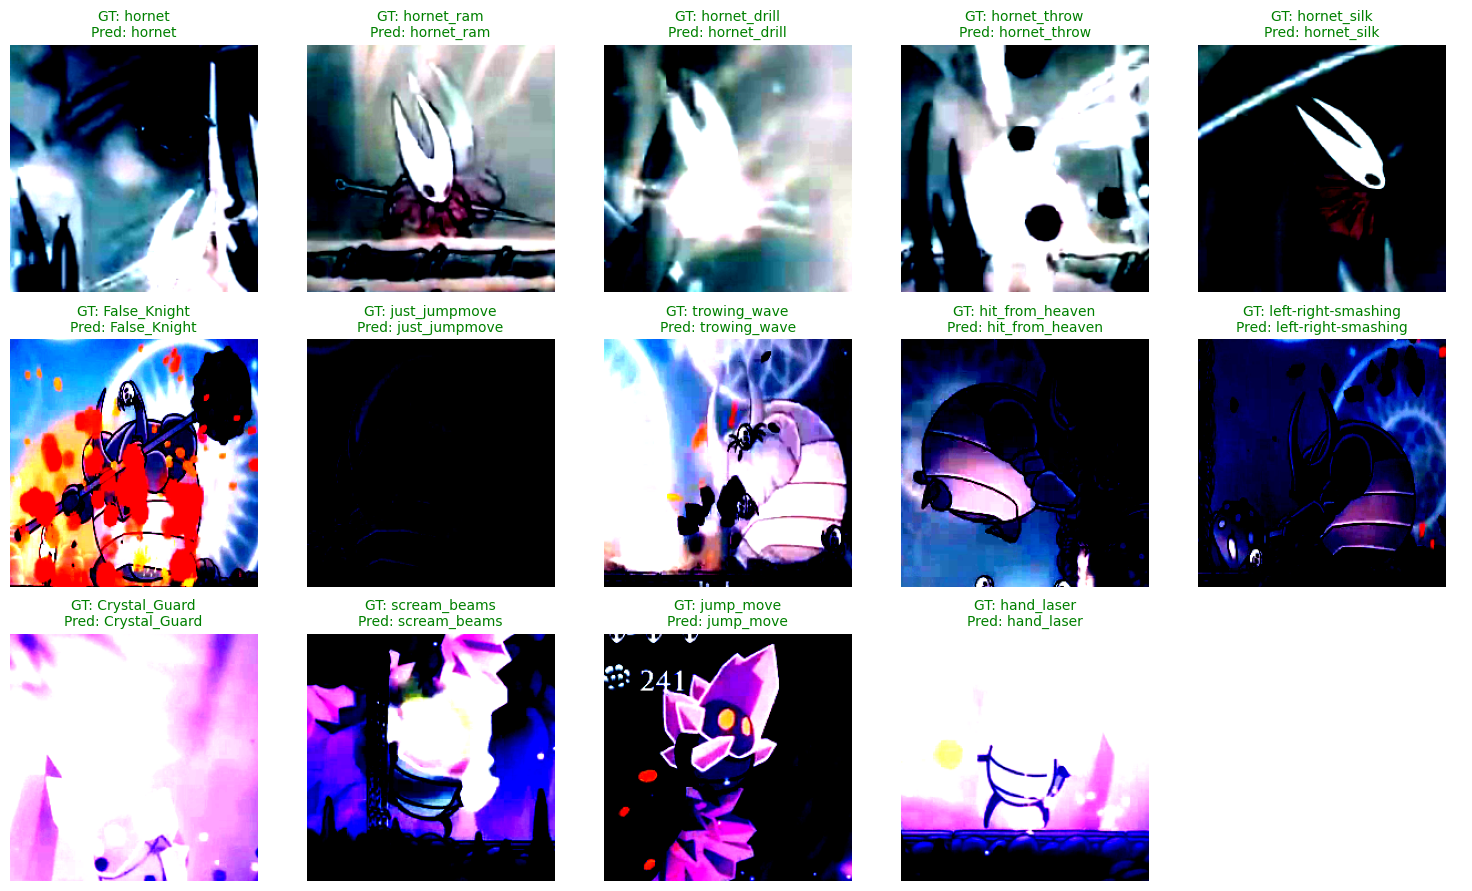

In [267]:
show_classified_crops(val_loader, test_model, val_ds.classes, "cuda")

In [263]:
def evaluate_model(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    print(f"Start evaluation on {len(loader.dataset)} samples...")

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Определяем, какие классы действительно присутствуют в данных
    unique_labels = sorted(set(all_labels) | set(all_preds))
    
    # Если переданы имена классов, выбираем только те, которые есть в данных
    if class_names is not None:
        # Проверяем, что индексы классов не выходят за пределы списка имен
        if max(unique_labels) >= len(class_names):
            print(f"Warning: Found label {max(unique_labels)}, but class_names has only {len(class_names)} names")
            # Используем числовые метки, если есть проблема с индексами
            display_class_names = None
        else:
            display_class_names = [class_names[i] for i in unique_labels]
    else:
        display_class_names = None

    print("\n" + "="*50)
    print("Classification Report (Precision, Recall, F1-Score per class):")
    print("="*50)
    print(classification_report(all_labels, all_preds, 
                               labels=unique_labels,
                               target_names=display_class_names, 
                               digits=4,
                               zero_division=0))
    print("="*50)

    # Строим confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    plt.figure(figsize=(10, 8))

    # Используем правильные подписи для осей
    if display_class_names is not None:
        tick_labels = display_class_names
    else:
        tick_labels = [f"Class {i}" for i in unique_labels]

    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d',   
        cmap='Blues', 
        xticklabels=tick_labels, 
        yticklabels=tick_labels
    )
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return all_labels, all_preds, unique_labels

In [264]:
val_ds.classes

['Crystal_Guard',
 'jump_move',
 'hand_laser',
 'scream_beams',
 'False_Knight',
 'trowing_wave',
 'hit_from_heaven',
 'left-right-smashing',
 'just_jumpmove',
 'hornet',
 'hornet_ram',
 'hornet_drill',
 'hornet_throw',
 'hornet_silk']

Детальная статистика по классам
Start evaluation on 1185 samples...


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.44it/s]



Classification Report (Precision, Recall, F1-Score per class):
                     precision    recall  f1-score   support

      Crystal_Guard     0.7143    0.5263    0.6061        38
          jump_move     0.9459    0.6604    0.7778        53
         hand_laser     0.8349    1.0000    0.9100        91
       scream_beams     0.8000    1.0000    0.8889        44
       False_Knight     0.7866    0.6684    0.7227       193
       trowing_wave     0.6042    0.6042    0.6042        48
    hit_from_heaven     0.7727    0.5426    0.6375        94
left-right-smashing     0.9722    0.6731    0.7955        52
      just_jumpmove     0.4286    0.8571    0.5714        70
             hornet     0.9086    0.9396    0.9239       381
         hornet_ram     0.6250    0.8824    0.7317        34
       hornet_drill     0.9677    1.0000    0.9836        30
       hornet_throw     0.7500    0.2727    0.4000        44
        hornet_silk     1.0000    1.0000    1.0000        13

           accuracy

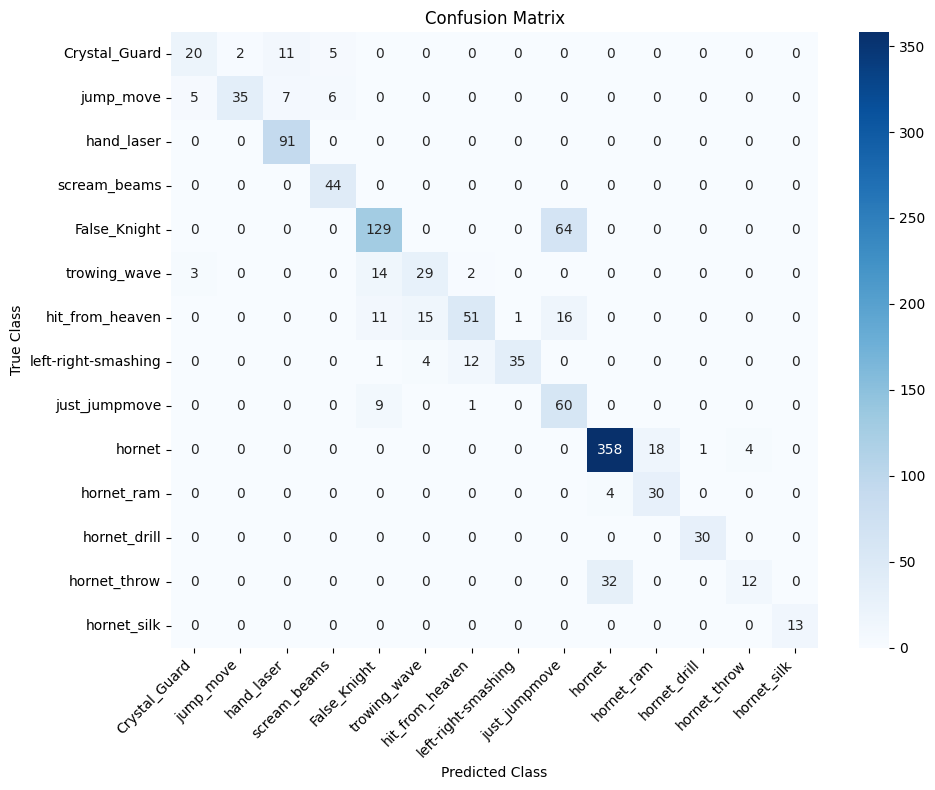

([np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64

In [268]:
print("Детальная статистика по классам")
all_val_labels = []
for images, labels in val_loader:
    all_val_labels.extend(labels.numpy())

unique_classes = sorted(set(all_val_labels))
available_class_names = [val_ds.classes[i] for i in unique_classes]

evaluate_model(
    model=test_model, 
    loader=val_loader, 
    device=device,
    class_names=available_class_names
)

In [ ]:
ATTACK_TO_ID

{'Crystal_Guard': 0,
 'jump_move': 1,
 'hand_laser': 2,
 'scream_beams': 3,
 'False_Knight': 4,
 'trowing_wave': 5,
 'hit_from_heaven': 6,
 'left-right-smashing': 7,
 'just_jumpmove': 8,
 'hornet': 9,
 'hornet_ram': 10,
 'hornet_drill': 11,
 'hornet_throw': 12,
 'hornet_silk': 13}